In [1]:
import numpy as np
from tqdm import tqdm
import csv
import torch
import torchvision.transforms as transforms
from timm.data import create_transform

from imagenet_dataloader import ImageNetwithLUAB, RRCFlipReturnParams

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import timm

In [3]:
root_train = "/mnt/qb/datasets/ImageNet2012/train/"
xml_path = "/mnt/qb/work/oh/owl156/train_xml/"

input_size = 224

_, transform_2nd, transform_final = create_transform(
    input_size=input_size,
    is_training=True,
    auto_augment=None,
    color_jitter=0,
    re_prob=0,
    interpolation="bicubic",
    separate=True,
)

dataset_train = ImageNetwithLUAB(
    root=root_train,
    xml_root=xml_path,
    num_classes=1000,
    transform=transforms.Compose([transform_2nd, transform_final]),
    pre_transform=RRCFlipReturnParams(
        size=input_size, scale=(0.08, 1), interpolation="bicubic"
    ),
    time_series_info=True
)

In [4]:
not_selected_indices = np.load('data/not_selected.npy')
selected_indices = np.load('data/selected.npy')

In [4]:
not_selected = torch.utils.data.Subset(dataset_train, not_selected_indices)
not_selected_loader = torch.utils.data.DataLoader(not_selected, batch_size=1, shuffle=False, num_workers=1)
iterator = enumerate(not_selected_loader)


In [3]:
loader = torch.utils.data.DataLoader(dataset_train, batch_size=1, shuffle=False, num_workers=1)
iterator = enumerate(loader)

In [7]:
idx = selected_indices[0]
image, label, weight, loc_info, selected_record, selected_record_time, selected, estimateTime, worker_id, assignment_id, selected_count, hovered_record, mouse_record = dataset_train[idx]

In [9]:
mouse_record = np.array(mouse_record)
mouse_record

array([[1.64094207e+12, 8.95000000e-01, 4.93333333e-01],
       [1.64094207e+12, 8.65000000e-01, 7.13333333e-01],
       [1.64094207e+12, 7.85000000e-01, 8.53333333e-01],
       [1.64094207e+12, 7.05000000e-01, 9.80000000e-01],
       [1.64094207e+12, 6.80000000e-01, 1.00000000e+00],
       [1.64094207e+12, 6.55000000e-01, 9.80000000e-01],
       [1.64094207e+12, 6.40000000e-01, 8.60000000e-01],
       [1.64094207e+12, 6.35000000e-01, 6.73333333e-01],
       [1.64094207e+12, 6.35000000e-01, 6.66666667e-01],
       [1.64094207e+12, 6.35000000e-01, 6.46666667e-01],
       [1.64094207e+12, 6.35000000e-01, 6.40000000e-01],
       [1.64094207e+12, 6.40000000e-01, 6.26666667e-01],
       [1.64094207e+12, 6.45000000e-01, 6.13333333e-01],
       [1.64094207e+12, 6.50000000e-01, 6.13333333e-01]])

In [10]:
image.show()

AttributeError: 'numpy.ndarray' object has no attribute 'show'

## Transforming file names into indices


In [5]:
with open('/mnt/qb/work/oh/owl156/NeglectedFreeLunch/data/fnames_clean.txt', 'r') as f:
    fnames = f.readlines()
    AWDWIN_fnames = fnames[0].split(',')
AWDWIN_fnames[:10],len(AWDWIN_fnames)

(['n02097047_2079.JPEG',
  'n01682714_8546.JPEG',
  'n03134739_3100.JPEG',
  'n04254777_3064.JPEG',
  'n02859443_5650.JPEG',
  'n02096177_2282.JPEG',
  'n02107683_5102.JPEG',
  'n01443537_18604.JPEG',
  'n02264363_4016.JPEG',
  'n03759954_24005.JPEG'],
 1148659)

In [14]:
awdwin_fnames = np.asarray(AWDWIN_fnames)
all_names = np.asarray([el[0].split('/')[-1] for el in dataset_train.samples])

In [38]:
_, AWDWIN_indices, _ = np.intersect1d(all_names, awdwin_fnames, assume_unique=True, return_indices=True)

In [39]:
assert len(AWDWIN_indices) == len(AWDWIN_fnames)
np.save('data/awdwin_indices.npy', AWDWIN_indices)

## Random subsample of the same size as AWDWIN

In [40]:
all_indices = np.arange(0, len(dataset_train))
size_subsample = len(AWDWIN_fnames)
new_random = all_indices[np.random.choice(all_indices, size_subsample, replace=False)]
new_random = np.sort(new_random)

In [41]:
new_random

array([      0,       1,       2, ..., 1281164, 1281165, 1281166])

In [43]:
assert len(new_random) == len(AWDWIN_fnames)
np.save('data/awdwin_random.npy', np.asarray(new_random))


## Visual inspection of not selected images

In [10]:
_, img = next(iterator)


In [14]:
img = img[0][0]
img.shape

torch.Size([224, 224, 3])

In [15]:
img = t2d(img)

In [17]:
(img* timm.data.constants.IMAGENET_DEFAULT_STD).shape

(224, 224, 3)

In [5]:
def t2d(t):
    return t.detach().cpu().numpy().astype(np.float64) 

(224, 224, 3)


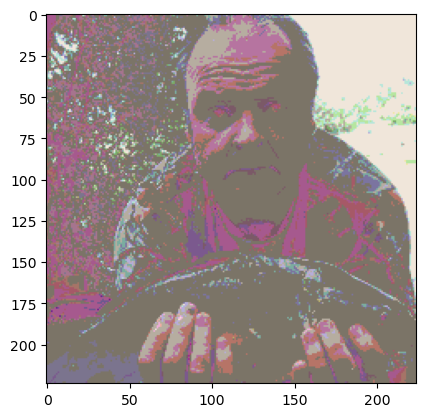

In [9]:
img = img[0][0]
img = ((t2d(img) * timm.data.constants.IMAGENET_DEFAULT_STD + timm.data.constants.IMAGENET_DEFAULT_MEAN))*255

print(img.shape)

imgplot = plt.imshow(img.astype(np.uint8))
plt.show()

## AB statistics
Extracting statistics

In [44]:
iterator = tqdm(dataset_train)
e = enumerate(iterator)
el = next(e)

  0%|          | 0/1281167 [00:00<?, ?it/s]

In [45]:
i, (image, label, weight, loc_info, selected_record, selected_record_time, selected, estimateTime, worker_id, assignment_id, selected_count) = el

In [ ]:
batch_size = 8
num_workers = 1
loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True, drop_last=False)


In [42]:
selected_count, estimateTime

(0, -1)

In [ ]:
iterator = tqdm(dataset_train)
not_selected = []
worker_sum = {}
worker_min = {}
worker_max = {}
worker_counts = {}
selected_count_freq = {}

print('Loop')
for i, (image, label, weight, loc_info, selected_record, selected_record_time, selected, estimateTime, worker_id, assignment_id, selected_count) in enumerate(iterator):
    workerid=worker_id
    if workerid not in worker_sum.keys():
        worker_sum[workerid] = estimateTime 
        worker_min[workerid] = estimateTime
        worker_max[workerid] = estimateTime 
        worker_counts[workerid] = 1 
    else:
        worker_sum[workerid] += estimateTime
        if worker_min[workerid] > estimateTime:
            worker_min[workerid] = estimateTime
        if worker_min[workerid] < estimateTime:
            worker_max[workerid] = estimateTime 
        worker_counts[workerid] += 1
    if selected_count not in selected_count_freq.keys():    
        selected_count_freq[selected_count] = 1
    else:
        selected_count_freq[selected_count] +=1
    if not i%10000:
        print(f"item {i} covariate {selected}, label {estimateTime}, workerid {workerid}, assignmentid {assignment_id}, Number of workers so Far{len(worker_min)}, selected_count_freq {selected_count_freq}")
    if not selected == 1:
        not_selected.append(i)

        

In [ ]:

# Save the indices of the elements to ignore
np.save('not_selected.npy', np.asarray(not_selected))

with open('writer_statistics.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile, delimiter=',', quotechar='|', quoting=csv.QUOTE_MINIMAL)
    writer.writerow(['writer_id', 'estimated_time_avg', 'estimated_time_max', 'estimated_time_min'])

    for key in worker_counts.keys():
        writer_id= worker_sum[key]   
        estimated_time_avg= worker_min[key]  
        estimated_time_max= worker_max[key]  
        estimated_time_min= worker_counts[key]  
        writer.writerow([f'{writer_id}', f'{estimated_time_avg}', f'{estimated_time_max}', f'{estimated_time_min}'])


        

## Random subsample of same size as selected 

In [ ]:
indices = np.load('data/selected.npy')
all_indices = np.arange(0, len(dataset_train))

new_random = all_indices[np.random.choice(all_indices, len(indices), replace=False)]
new_random = np.sort(new_random)

np.save('86_AB_random5.npy', np.asarray(new_random))
